![data-x](https://raw.githubusercontent.com/afo/data-x-plaksha/master/imgsource/dx_logo.png)


# __Titanic Survivor Analysis__

#### Author (first part): Several public Kaggle Kernels
#### Edits: Alexander Fred Ojala, Kevin Li, Elias Castro Hernandez, and Zhi Li

**Sources:** 
* **Training + explanations**: https://www.kaggle.com/c/titanic

-----

#### **New Fall 2021**

**Author (ensemble part)**: Mario Filho & Derek S. Chan

**Reviewer (ensemble part)**: Derek S. Chan

**Note**: New ensemble part was written fast to start to introduce additional better practices week 5

**Updated**: 9/25/2021, 11:00am PST




**Recommendation**: It might be easier to run the notebook in Colab (via Google Drive), which has pre-installed dependencies for the new ensemble part.

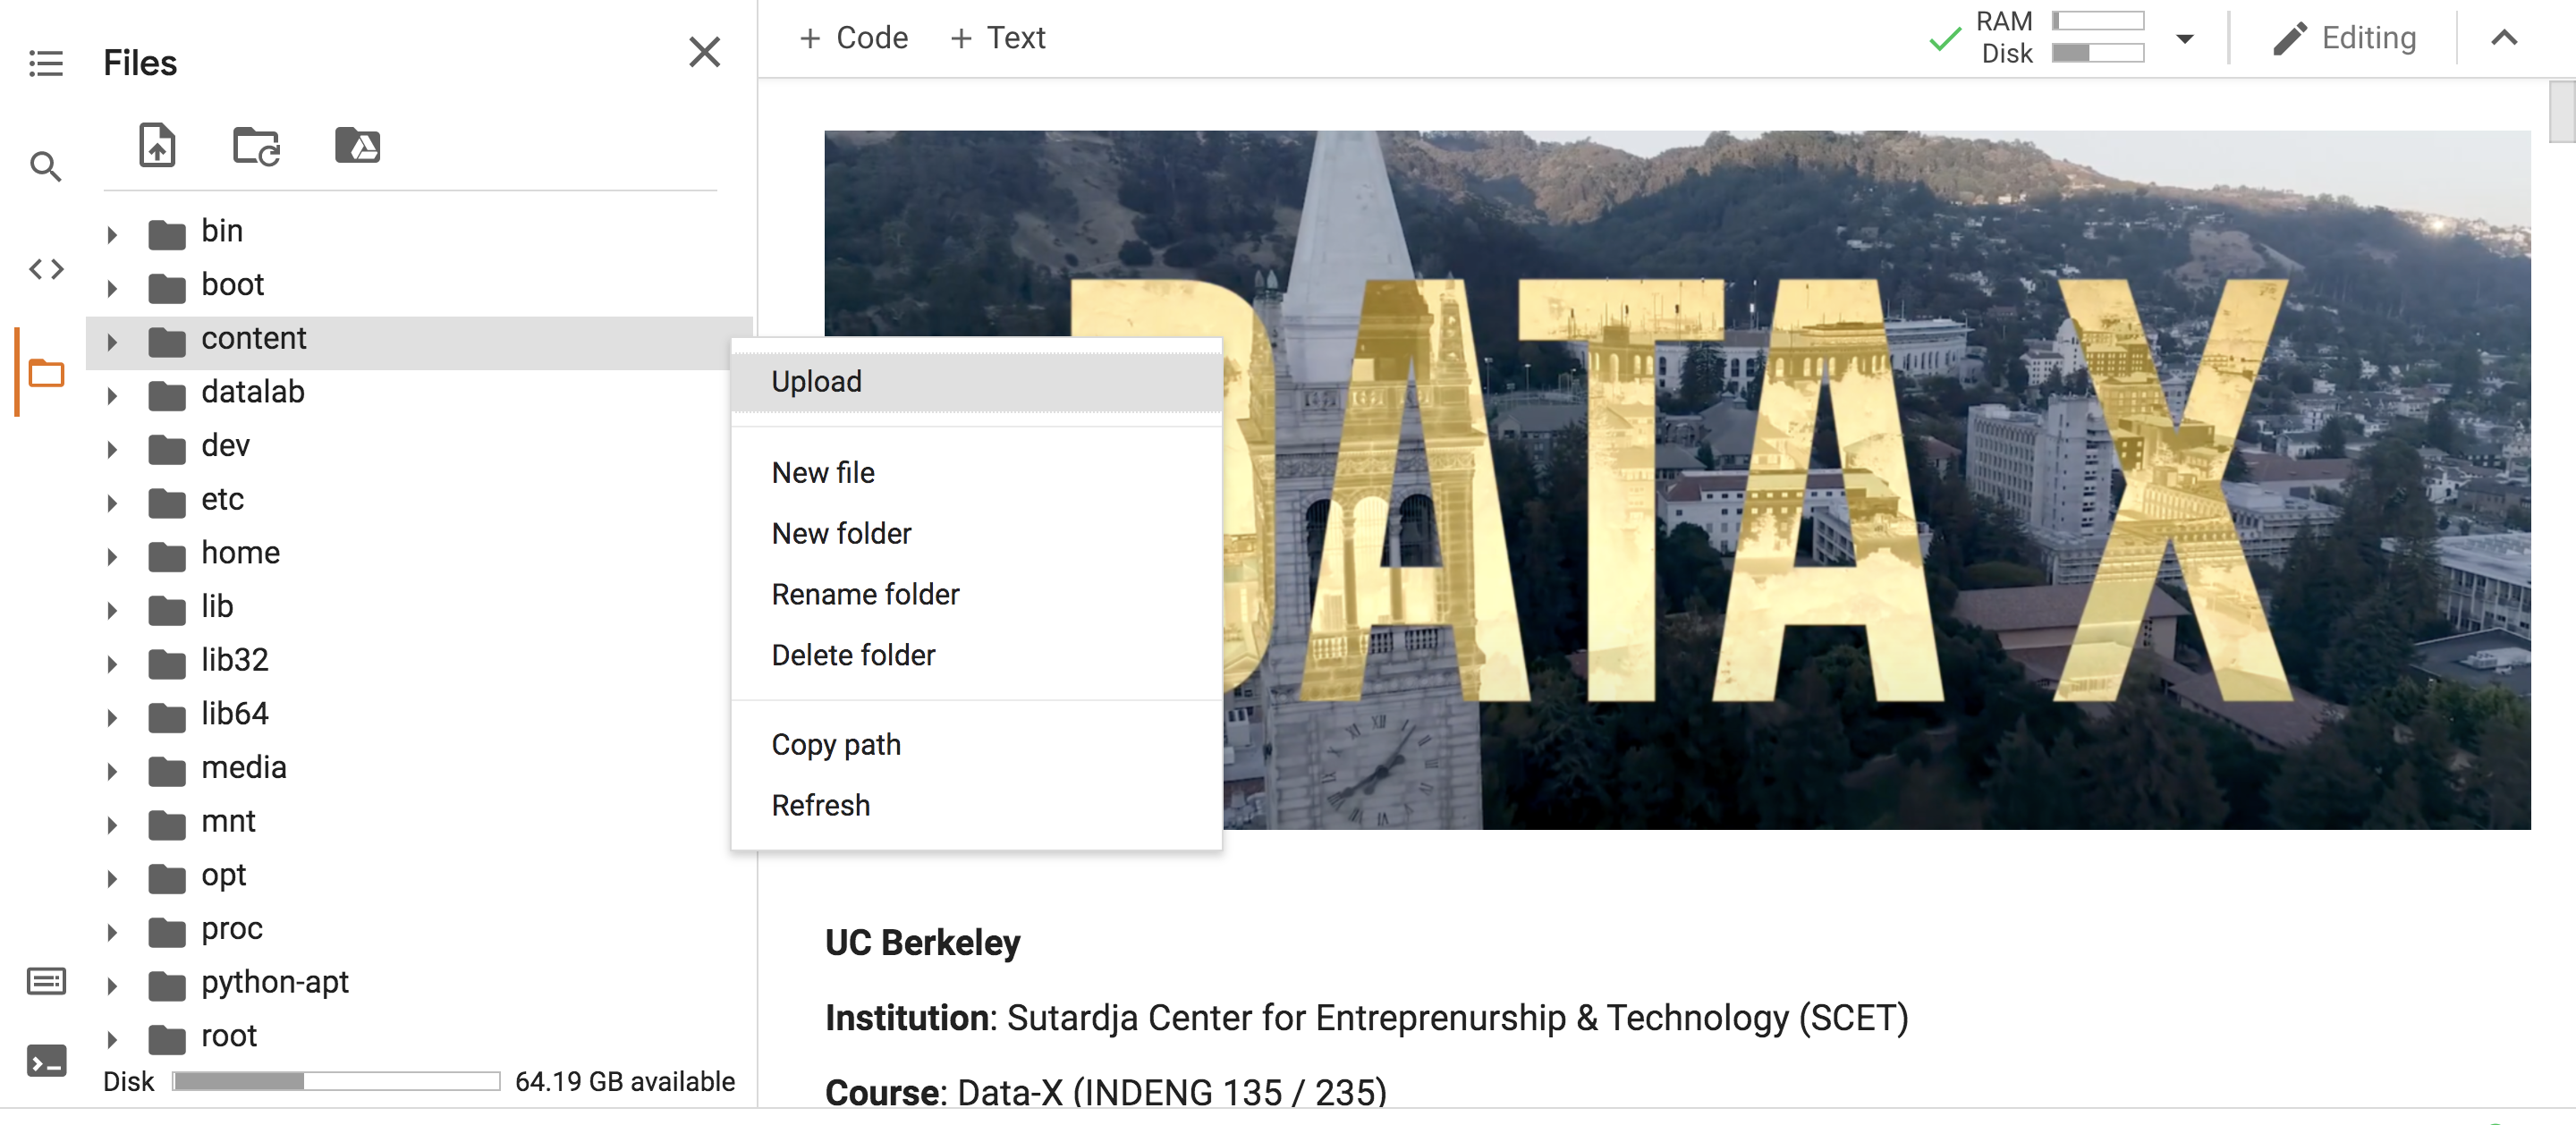


# Understanding the connections between passanger information and survival rate

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

<br>
The data conists of passanger information for the maiden, and tragic, voyage of the Titanic ocean liner. The set is comprised of 1309 unique entries, each associated with information realated to a passanger. The set is broken is broken down to 891/328 (testing/training) split for the purposes of modeling

**Our task is to train a machine learning model on the training set in order to predict if the passengers in the test set survived or not.**

<br>

### Table of Contents

> #### [Part 0: Install Additional Required Software](#sec0)

> #### [Part 1: Import Packages + Libraries + Dependencies](#sec1)

> #### [Part 2: Exploring and Understanding the Data](#sec2)

> #### [Part 3: Establishing Hypotheses and Data Preprocessing](#sec3)

> #### [Part 4: Machine Learning!](#sec4)

### Additional Material

> #### [Appendix I: Why are our models maxing out at around 80%?](#appendix1)

> #### [Appendix II: Resources and references to material we won't cover in detail](#appendix2)

<br>

___
___

<a id='sec1'></a>
___
## Part 1: Import Packages + Libraries + Dependencies

### Import packages

In [ ]:
# No warnings
import warnings
warnings.filterwarnings('ignore') # Filter out warnings

# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB # Gaussian Naive Bayes
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb

submission = pd.read_csv('gender_submission.csv')
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


### Styling and fancy distribution plot

In [ ]:
# Plot styling and display options
sns.set(style='white', context='notebook', palette='deep')
plt.rcParams[ 'figure.figsize' ] = 10 , 6

pd.set_option('display.max_columns', 100) # Print 100 Pandas columns

# Special distribution plot (will be used later)
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()
    plt.tight_layout()

### Load Data

In [ ]:
!head train.csv

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,,S
6,0,3,"Moran, Mr. James",male,,0,0,330877,8.4583,,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.075,,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,,S


In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# # Change the dataframes naming format into that of the historical titanic notebook
# train_df = train_df.rename(columns={'Passenger_Id':'PassengerId', 
#                          'survived': 'Survived',
#                          'pclass': 'Pclass',
#                          'name_with_salutions':'Name',
#                          'sex':'Sex',
#                          'age':'Age',
#                          'sibsp':'SibSp',
#                          'parch':'Parch',
#                          'ticket':'Ticket',
#                          'fare':'Fare',
#                          'cabin':'Cabin',
#                          'embarked':'Embarked'})
# test_df = test_df.rename(columns={'Passenger_Id':'PassengerId', 
#                          'survived': 'Survived',
#                          'pclass': 'Pclass',
#                          'name_with_salutions':'Name',
#                          'sex':'Sex',
#                          'age':'Age',
#                          'sibsp':'SibSp',
#                          'parch':'Parch',
#                          'ticket':'Ticket',
#                          'fare':'Fare',
#                          'cabin':'Cabin',
#                          'embarked':'Embarked'})
combine = [train_df, test_df]
# combine is used to ensure whatever preprocessing is done on training data
# is also done on test data

# NOTE! When we change train_df or test_df the objects in combine 
# will also change (combine is only a pointer to the objects)

<a id='sec2'></a>
___
## Part 2: Exploring and Understanding the Data
**Data descriptions**

<img src="data/Titanic_Variable.png">

In [ ]:
# Features/Variable names
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [ ]:
# preview the data
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# General data statistics
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
# Data Frame information (null, data type etc)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Histograms

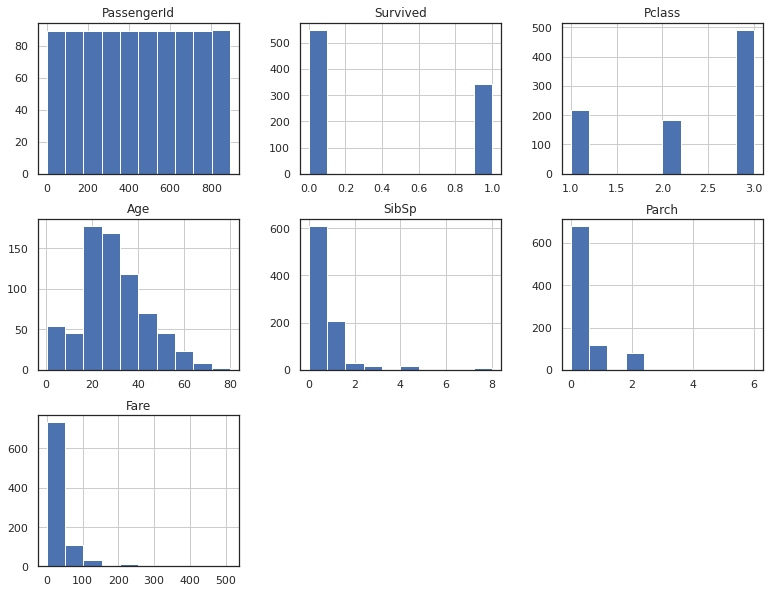

In [ ]:
train_df.hist(figsize=(13,10))
plt.show()

In [ ]:
# Balanced data set?
target_count = train_df['Survived'].value_counts()
target_count

0    549
1    342
Name: Survived, dtype: int64

__Note:__ If the goal is Prediction, unbalanced data introduce bias into model. 

Balanced data are good for classification, but you lose information such as appearance frequencies -- which may affect accuracy metrics themselves, as well as production performance.

In [ ]:
# What is base line for prediction accuracy?
target_count[0]/(sum(target_count)) 

0.6161616161616161

___

> #### __Brief Remarks Regarding the Data__

> * `PassengerId` is a random number (incrementing index) and thus does not contain any valuable information. 

> * `Survived, Passenger Class, Age, Siblings Spouses, Parents Children` and `Fare` are numerical values (no need to transform them) -- but, we might want to group them (i.e. create categorical variables). 

> * `Sex, Embarked` are categorical features that we need to map to integer values. `Name, Ticket` and `Cabin` might also contain valuable information.

___

### Dropping Redundant Data
__Note:__ It is important to remove variables that convey information already captured by some other variable. Doing so removes the correlation, while also diminishing potential overfit.

In [ ]:
# Check dimensions of the train and test datasets
print("Shapes Before: (train) (test) = ", \
      train_df.shape, test_df.shape)

Shapes Before: (train) (test) =  (891, 12) (418, 11)


In [ ]:
# Drop a few columns, need to do it for both test and training
train_df = train_df.drop(['PassengerId'], axis=1)
combine = [train_df, test_df]
print("Shapes After: (train) (test) =", train_df.shape, test_df.shape)

Shapes After: (train) (test) = (891, 11) (418, 11)


In [ ]:
# Check if there are null values in the datasets
print(train_df.isnull().sum())
print()
print(test_df.isnull().sum())

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


<a id='sec3'></a>
____
## Part 3: Establishing Hypotheses and Data Preprocessing

### _The Title of the person is a feature that can predict survival_

In [ ]:
# List example titles in Name column
train_df.Name[:5]

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [ ]:
# from the Name column we will extract title of each passenger
# and save that in a column in the dataset called 'Title'
# if you want to match Titles or Names with any other expression
# refer to this tutorial on regex in python:
# https://www.tutorialspoint.com/python/python_reg_expressions.htm

# Create column called Title
for dataset in combine:
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [ ]:
# Double check that our titles makes sense (by comparing to sex)
pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


>___
> #### __Jonkheer?__ 

> Most popular during medieval times, the title of _Jonkheer_ was given to a young and unmarried child of a high-ranking knight or nobleman -- __Considered the lowest rank of nobility.__

>___

In [ ]:
# same but for test set
pd.crosstab(test_df['Title'], test_df['Sex'])

Sex,female,male
Title,,
Col,0,2
Dona,1,0
Dr,0,1
Master,0,21
Miss,78,0
Mr,0,240
Mrs,72,0
Ms,1,0
Rev,0,2


In [ ]:
# We see common titles like Miss, Mrs, Mr, Master are dominant, we will
# correct some Titles to standard forms and replace the rarest titles 
# with single name 'Rare'
for dataset in combine:
    dataset['Title'] = dataset['Title'].\
                  replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr',\
                 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss') #Mademoiselle
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs') #Madame

In [ ]:
# We now have more logical (contemporary) titles, and fewer groups
train_df[['Title', 'Survived']].groupby(['Title']).mean()

,Survived
Title,
Master,0.575000
Miss,0.702703
Mr,0.156673
Mrs,0.793651
Rare,0.347826


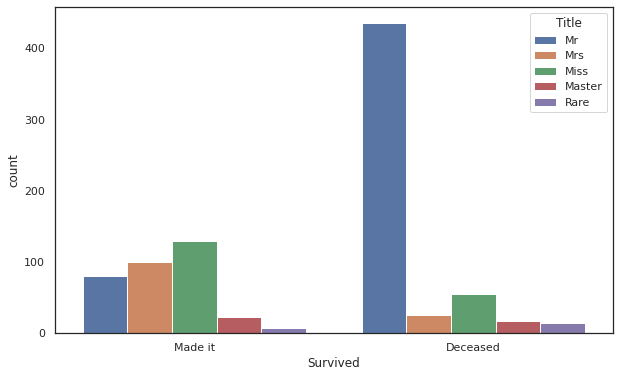

In [ ]:
# We can plot the survival chance for each title
sns.countplot(x='Survived', hue="Title", data=train_df, order=[1,0])
plt.xticks(range(2),['Made it','Deceased']);

In [ ]:
# Title dummy mapping: Map titles to binary dummy columns
for dataset in combine:
    binary_encoded = pd.get_dummies(dataset.Title)
    newcols = binary_encoded.columns
    dataset[newcols] = binary_encoded

train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Master,Miss,Mr,Mrs,Rare
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,0,0,1,0,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,0,0,0,1,0
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0,1,0,0,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,0,0,0,1,0
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,0,0,1,0,0


In [ ]:
# Remove unique variables for analysis (Title is generally bound to Name, so it's also dropped)
train_df = train_df.drop(['Name', 'Title'], axis=1)
test_df = test_df.drop(['Name', 'Title'], axis=1)
combine = [train_df, test_df]

In [ ]:
# sanity check
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Master,Miss,Mr,Mrs,Rare
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1,0,0
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,0,0,0,1,0
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,0,0,0
3,1,1,female,35.0,1,0,113803,53.1000,C123,S,0,0,0,1,0
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S,0,0,1,0,0


### Map Sex column to binary (male = 0, female = 1) categories

In [ ]:
# convert categorical variable to numeric
for dataset in combine:
    dataset['Sex'] = dataset['Sex']. \
        map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Master,Miss,Mr,Mrs,Rare
0,0,3,0,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1,0,0
1,1,1,1,38.0,1,0,PC 17599,71.2833,C85,C,0,0,0,1,0
2,1,3,1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,0,0,0
3,1,1,1,35.0,1,0,113803,53.1000,C123,S,0,0,0,1,0
4,0,3,0,35.0,0,0,373450,8.0500,NaN,S,0,0,1,0,0


### Handle missing values for age
We will now guess values of age based on sex (male / female) 
and socioeconomic class (1st, 2nd, 3rd) of the passenger.

The row indicates the sex, male = 0, female = 1

> __IDEA:__ Wealth (indicated by class accomodation), as well as Gender, historically are indicative of age. 

> This approach gives us a more refined estimate than only taking the median / mean, etc. 

In [ ]:
# create empty array  for later use
guess_ages = np.zeros((2,3),dtype=int) 
guess_ages

array([[0, 0, 0],
       [0, 0, 0]])

In [ ]:
# Fill the NA's for the Age columns
# with "qualified guesses"

for idx,dataset in enumerate(combine):  
    # method adds a counter to an iterable and returns it in a form of enumerate object.     
    if idx==0:
        print('Working on Training Data set\n')
    else:
        print('-'*35)
        print('Working on Test Data set\n')
    
    print('Guess values of age based on sex and pclass of the passenger...')
    for i in range(0, 2):
        for j in range(0,3):
            guess_df = dataset[(dataset['Sex'] == i) \
                        &(dataset['Pclass'] == j+1)]['Age'].dropna()

            # Extract the median age for this group
            # (less sensitive) to outliers
            age_guess = guess_df.median()
          
            # Convert random age float to int
            guess_ages[i,j] = int(age_guess)
    
            
    print('Guess_Age table:\n',guess_ages)
    print ('\nAssigning age values to NAN age values in the dataset...')
    
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) \
                    & (dataset.Pclass == j+1),'Age'] = guess_ages[i,j]
                    

    dataset['Age'] = dataset['Age'].astype(int)
    print()
print('Done! \n\n\n')
train_df.head()

Working on Training Data set

Guess values of age based on sex and pclass of the passenger...
Guess_Age table:
 [[40 30 25]
 [35 28 21]]

Assigning age values to NAN age values in the dataset...

-----------------------------------
Working on Test Data set

Guess values of age based on sex and pclass of the passenger...
Guess_Age table:
 [[42 28 24]
 [41 24 22]]

Assigning age values to NAN age values in the dataset...

Done! 





,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Master,Miss,Mr,Mrs,Rare
0,0,3,0,22,1,0,A/5 21171,7.2500,NaN,S,0,0,1,0,0
1,1,1,1,38,1,0,PC 17599,71.2833,C85,C,0,0,0,1,0
2,1,3,1,26,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,0,0,0
3,1,1,1,35,1,0,113803,53.1000,C123,S,0,0,0,1,0
4,0,3,0,35,0,0,373450,8.0500,NaN,S,0,0,1,0,0


### Split age into bands / categorical ranges and look at survival rates

In [ ]:
# Age bands
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False)\
                    .mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


### Distribution of suvival relative to age

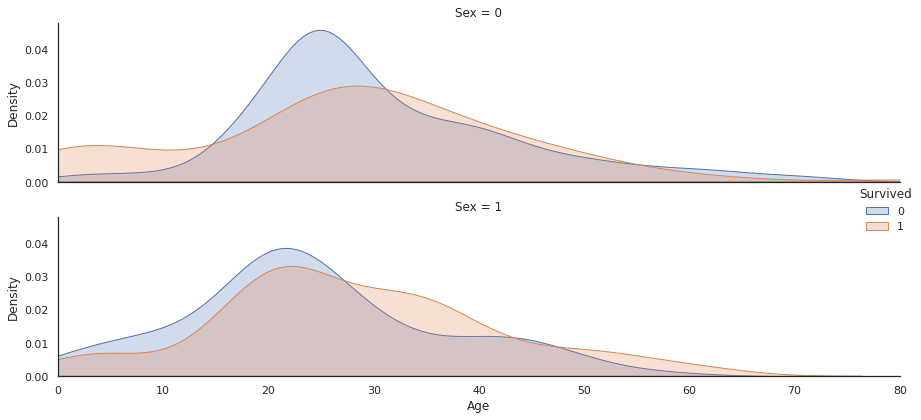

In [ ]:
# Plot distributions of Age of passangers who survived 
# or did not survive
plot_distribution( train_df , var = 'Age' , target = 'Survived', row = 'Sex' )

# Recall: {'male': 0, 'female': 1}

In [ ]:
# Change Age column to
# map Age ranges (AgeBands) to integer values of categorical type 
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4
train_df.head()

# Note we could just run 
# dataset['Age'] = pd.cut(dataset['Age'], 5,labels=[0,1,2,3,4])

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Master,Miss,Mr,Mrs,Rare,AgeBand
0,0,3,0,1,1,0,A/5 21171,7.2500,NaN,S,0,0,1,0,0,"(16.0, 32.0]"
1,1,1,1,2,1,0,PC 17599,71.2833,C85,C,0,0,0,1,0,"(32.0, 48.0]"
2,1,3,1,1,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,0,0,0,"(16.0, 32.0]"
3,1,1,1,2,1,0,113803,53.1000,C123,S,0,0,0,1,0,"(32.0, 48.0]"
4,0,3,0,2,0,0,373450,8.0500,NaN,S,0,0,1,0,0,"(32.0, 48.0]"


In [ ]:
# remove AgeBand column
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Master,Miss,Mr,Mrs,Rare
0,0,3,0,1,1,0,A/5 21171,7.2500,NaN,S,0,0,1,0,0
1,1,1,1,2,1,0,PC 17599,71.2833,C85,C,0,0,0,1,0
2,1,3,1,1,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,0,0,0
3,1,1,1,2,1,0,113803,53.1000,C123,S,0,0,0,1,0
4,0,3,0,2,0,0,373450,8.0500,NaN,S,0,0,1,0,0


### Travel Party Size

How did the number of people the person traveled with impact the chance of survival?

In [ ]:
# SibSp = Number of Sibling / Spouses
# Parch = Parents / Children
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

    
# Survival chance against FamilySize
train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=True) \
                                .mean().sort_values(by='Survived', ascending=False)

,Survived
FamilySize,
4,0.724138
3,0.578431
2,0.552795
7,0.333333
1,0.303538
5,0.200000
6,0.136364
8,0.000000
11,0.000000


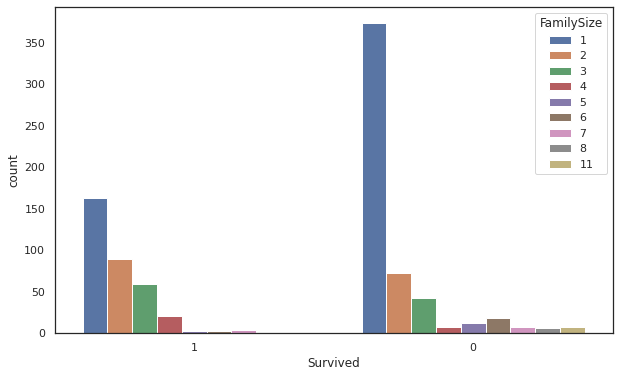

In [ ]:
# Plot it, 1 is survived
sns.countplot(x='Survived', hue="FamilySize", data=train_df, order=[1,0]);

In [ ]:
# Create binary variable if the person was alone or not
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=True).mean()

,Survived
IsAlone,
0,0.505650
1,0.303538


In [ ]:
# We will only use the binary IsAlone feature for further analysis
for df in combine:
    df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1, inplace=True)

train_df.head()

,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Master,Miss,Mr,Mrs,Rare,IsAlone
0,0,3,0,1,A/5 21171,7.2500,NaN,S,0,0,1,0,0,0
1,1,1,1,2,PC 17599,71.2833,C85,C,0,0,0,1,0,0
2,1,3,1,1,STON/O2. 3101282,7.9250,NaN,S,0,1,0,0,0,1
3,1,1,1,2,113803,53.1000,C123,S,0,0,0,1,0,0
4,0,3,0,2,373450,8.0500,NaN,S,0,0,1,0,0,1


# Feature construction

In [ ]:
# We can also create new features based on intuitive combinations
# Here is an example when we say that the age times socioclass is a determinant factor
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head()

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3


In [ ]:
train_df[['Age*Class', 'Survived']].groupby(['Age*Class'], as_index=True).mean()

,Survived
Age*Class,
0,0.550000
1,0.728814
2,0.520408
3,0.277487
4,0.415094
6,0.149425
8,0.000000
9,0.111111
12,0.000000


### Port the person embarked from
Let's see how that influences chance of survival

<img src= "data/images/titanic_voyage_map.png">
>___

> #### __Interesting Fact:__ 

> Third Class passengers were the first to board, with First and Second Class passengers following up to an hour before departure. 

> Third Class passengers were inspected for ailments and physical impairments that might lead to their being refused entry to the United States, while First Class passengers were personally greeted by Captain Smith.

In [ ]:
# To replace Nan value in 'Embarked', we will use the mode
# in 'Embaraked'. This will give us the most frequent port 
# the passengers embarked from
freq_port = train_df['Embarked'].dropna().mode()[0]
print('Most frequent port of Embarkation:',freq_port)

Most frequent port of Embarkation: S


In [ ]:
# Fill NaN 'Embarked' Values in the datasets
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=True) \
                    .mean().sort_values(by='Survived', ascending=False)

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.339009


### Survival relative to port of origin

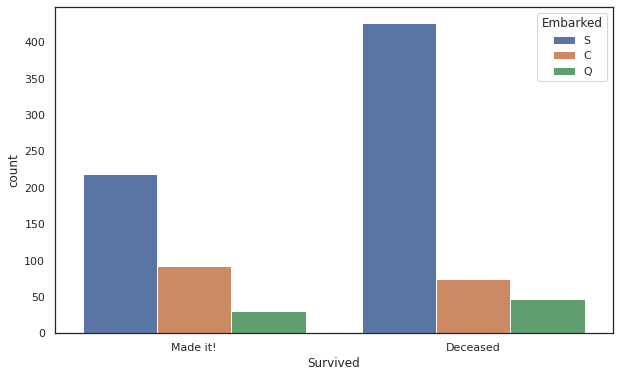

In [ ]:
# Plot of relationship between survival and origin 
sns.countplot(x='Survived', hue="Embarked", data=train_df, order=[1,0])
plt.xticks(range(2),['Made it!', 'Deceased']);

In [ ]:
# Create categorical dummy variables for Embarked values
for dataset in combine:
    binary_encoded = pd.get_dummies(dataset.Embarked)
    newcols = binary_encoded.columns
    dataset[newcols] = binary_encoded
    
train_df.head()

,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Master,Miss,Mr,Mrs,Rare,IsAlone,Age*Class,C,Q,S
0,0,3,0,1,A/5 21171,7.2500,NaN,S,0,0,1,0,0,0,3,0,0,1
1,1,1,1,2,PC 17599,71.2833,C85,C,0,0,0,1,0,0,2,1,0,0
2,1,3,1,1,STON/O2. 3101282,7.9250,NaN,S,0,1,0,0,0,1,3,0,0,1
3,1,1,1,2,113803,53.1000,C123,S,0,0,0,1,0,0,2,0,0,1
4,0,3,0,2,373450,8.0500,NaN,S,0,0,1,0,0,1,6,0,0,1


In [ ]:
# Drop Embarked
for dataset in combine:
    dataset.drop('Embarked', axis=1, inplace=True)

### Fare Amount
What is the relationship between _Fare_ and survival

In [ ]:
# Fill the NA values in the Fares column with the median
train_df['Fare'].fillna(train_df['Fare'].dropna().median(), inplace=True)
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
train_df.head()

,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Master,Miss,Mr,Mrs,Rare,IsAlone,Age*Class,C,Q,S
0,0,3,0,1,A/5 21171,7.2500,NaN,0,0,1,0,0,0,3,0,0,1
1,1,1,1,2,PC 17599,71.2833,C85,0,0,0,1,0,0,2,1,0,0
2,1,3,1,1,STON/O2. 3101282,7.9250,NaN,0,1,0,0,0,1,3,0,0,1
3,1,1,1,2,113803,53.1000,C123,0,0,0,1,0,0,2,0,0,1
4,0,3,0,2,373450,8.0500,NaN,0,0,1,0,0,1,6,0,0,1


In [ ]:
# q cut will find ranges equal to the quartile of the data
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [ ]:
for dataset in combine:
    dataset['Fare'] = pd.qcut(dataset['Fare'], 4, labels=np.arange(4))
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df[['Fare','FareBand']].head()

,Fare,FareBand
0,0,"(-0.001, 7.91]"
1,3,"(31.0, 512.329]"
2,1,"(7.91, 14.454]"
3,3,"(31.0, 512.329]"
4,1,"(7.91, 14.454]"


In [ ]:
# Drop FareBand
train_df = train_df.drop(['FareBand'], axis=1) 
combine = [train_df, test_df]

### Cabin
Is _Cabin_ useful in the prediciton?

In [ ]:
train_df.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [ ]:
train_df['CabinType'] = train_df['Cabin'].apply(lambda x: str(x)[0] if pd.notnull(x) else None)

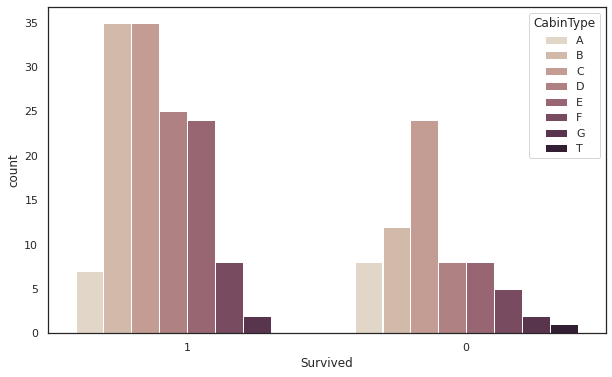

In [ ]:
sns.countplot(x='Survived',
              hue="CabinType",
              palette="ch:.25",
              data=train_df.sort_values(by='CabinType'),
              order=[1,0]);

In [ ]:
train_df['CabinType'].isnull().sum()

687

In [ ]:
len(train_df['CabinType'])

891

In [ ]:
train_df = train_df.drop(['Cabin', 'CabinType'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)
combine = [train_df, test_df]

In [ ]:
train_df.head()

,Survived,Pclass,Sex,Age,Ticket,Fare,Master,Miss,Mr,Mrs,Rare,IsAlone,Age*Class,C,Q,S
0,0,3,0,1,A/5 21171,0,0,0,1,0,0,0,3,0,0,1
1,1,1,1,2,PC 17599,3,0,0,0,1,0,0,2,1,0,0
2,1,3,1,1,STON/O2. 3101282,1,0,1,0,0,0,1,3,0,0,1
3,1,1,1,2,113803,3,0,0,0,1,0,0,2,0,0,1
4,0,3,0,2,373450,1,0,0,1,0,0,1,6,0,0,1


### Ticket
How about Ticket?

In [ ]:
train_df.Ticket.head(20)

0            A/5 21171
1             PC 17599
2     STON/O2. 3101282
3               113803
4               373450
5               330877
6                17463
7               349909
8               347742
9               237736
10             PP 9549
11              113783
12           A/5. 2151
13              347082
14              350406
15              248706
16              382652
17              244373
18              345763
19                2649
Name: Ticket, dtype: object

In [ ]:
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)
combine = [train_df, test_df]

In [ ]:
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Master,Miss,Mr,Mrs,Rare,IsAlone,Age*Class,C,Q,S
0,0,3,0,1,0,0,0,1,0,0,0,3,0,0,1
1,1,1,1,2,3,0,0,0,1,0,0,2,1,0,0
2,1,3,1,1,1,0,1,0,0,0,1,3,0,0,1
3,1,1,1,2,3,0,0,0,1,0,0,2,0,0,1
4,0,3,0,2,1,0,0,1,0,0,1,6,0,0,1


### Finished -- Preprocessing Complete!

In [ ]:
# All features are approximately on the same scale
# no need for feature engineering / normalization
train_df.head(7)

,Survived,Pclass,Sex,Age,Fare,Master,Miss,Mr,Mrs,Rare,IsAlone,Age*Class,C,Q,S
0,0,3,0,1,0,0,0,1,0,0,0,3,0,0,1
1,1,1,1,2,3,0,0,0,1,0,0,2,1,0,0
2,1,3,1,1,1,0,1,0,0,0,1,3,0,0,1
3,1,1,1,2,3,0,0,0,1,0,0,2,0,0,1
4,0,3,0,2,1,0,0,1,0,0,1,6,0,0,1
5,0,3,0,1,1,0,0,1,0,0,1,3,0,1,0
6,0,1,0,3,3,0,0,1,0,0,1,3,0,0,1


In [ ]:
test_df.head(7)

,PassengerId,Pclass,Sex,Age,Fare,Master,Miss,Mr,Mrs,Rare,IsAlone,Age*Class,C,Q,S
0,892,3,0,2,0,0,0,1,0,0,1,6,0,1,0
1,893,3,1,2,0,0,0,0,1,0,0,6,0,0,1
2,894,2,0,3,1,0,0,1,0,0,1,6,0,1,0
3,895,3,0,1,1,0,0,1,0,0,1,3,0,0,1
4,896,3,1,1,1,0,0,0,1,0,0,3,0,0,1
5,897,3,0,0,1,0,0,1,0,0,1,0,0,0,1
6,898,3,1,1,0,0,1,0,0,0,1,3,0,1,0


### Sanity Check: View the correlation between features in our processed dataset

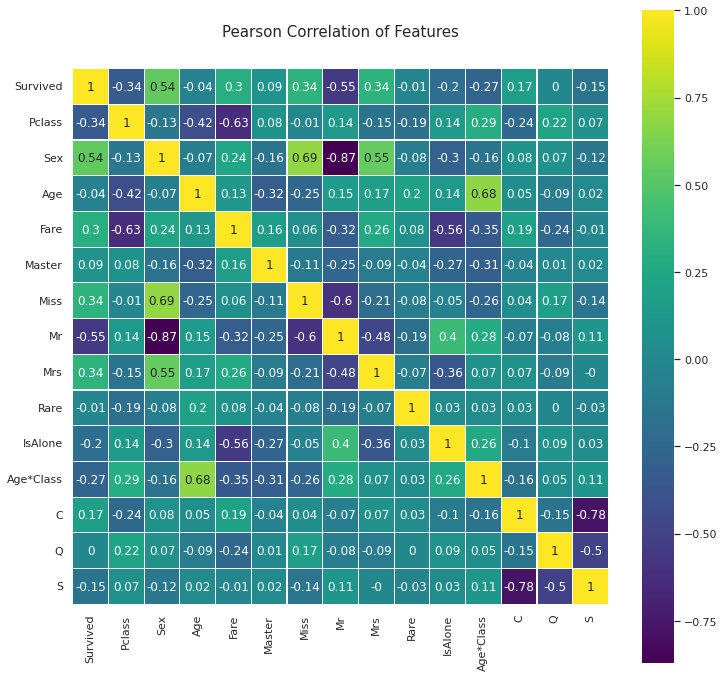

In [ ]:
# Uncorrelated features are generally more powerful predictors
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_df.corr().round(2)\
            ,linewidths=0.1,vmax=1.0, square=True, cmap=colormap, \
            linecolor='white', annot=True);

# Ensemble Part
For this notebook, optimize for ROC AUC to not be dependent on the threshold. But optimizing for accuracy directly may help. 

Note: https://www.kaggle.com/andreshg/automl-libraries-comparison

# LightAutoML

In [ ]:
!pip install -U lightautoml

In [ ]:
# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.tasks import Task
from sklearn.metrics import roc_auc_score

import torch

N_THREADS = 4 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 300 # Time in seconds for automl run

np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

def acc_score(y_true, y_pred, **kwargs):
    return roc_auc_score(y_true, y_pred , **kwargs)

task = Task('binary', metric = acc_score)

roles = {
    'target': 'Survived',
    'drop': ['Passengerid', 'Name', 'Ticket'],
}

automl = TabularUtilizedAutoML(task = task, # select if regression, binary classification, etc
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       # list inside a list, so single-level trial of models
                       # logistic regression, light GBM, and light GMB tuned
                       general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned']]}, 
                       reader_params = {'n_jobs': N_THREADS})
oof_pred = automl.fit_predict(train_df, roles = roles)
print('oof_pred:\n{}\nShape = {}'.format(oof_pred[:10], oof_pred.shape))

test_pred = automl.predict(test_df)
print('Prediction for test data:\n{}\nShape = {}'.format(test_pred[:10], test_pred.shape))

print('Check scores...')
print('OOF score: {}'.format(acc_score(train_df['Survived'].values, oof_pred.data[:, 0])))

#submission['Survived'] = (test_pred.data[:, 0] > 0.5).astype(int)
#submission.to_csv('lightautoml_utilized_300s_f1_metric.csv', index = False)
#submission.head()

Current random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
Found reader_params in kwargs, need to combine
Merged variant for reader_params = {'n_jobs': 4, 'random_state': 42}
Found general_params in kwargs, need to combine
Merged variant for general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned']], 'return_all_predictions': False}
Start automl preset with listed constraints:
- time: 299.9826776981354 seconds
- cpus: 4 cores
- memory: 16 gb

Train data shape: (891, 15)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 290.0509796142578 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.8646245059288536
Linear model: C = 5e-05 score = 0.8651515151515151
Linear model: C = 0.0001 score = 0.8648880105401845
Linear model: C = 0.0005 score = 0.868840579710145
Linear model: C = 

Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's binary_logloss: 0.464904	valid's Opt metric: 0.890053
[200]	valid's binary_logloss: 0.413315	valid's Opt metric: 0.896113
[300]	valid's binary_logloss: 0.398781	valid's Opt metric: 0.897167
[400]	valid's binary_logloss: 0.397373	valid's Opt metric: 0.898221
[500]	valid's binary_logloss: 0.397572	valid's Opt metric: 0.89809
Early stopping, best iteration is:
[370]	valid's binary_logloss: 0.395998	valid's Opt metric: 0.898748
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's binary_logloss: 0.495907	valid's Opt metric: 0.873715
[200]	valid's binary_logloss: 0.444836	valid's Opt metric: 0.876614
[

In [ ]:
submission['Survived'] = test_pred.data[:, 0] 
submission.to_csv('lightautoml_utilized_300s_test.csv', index = False)
submission.head()

,PassengerId,Survived
0,892,0.084940
1,893,0.392338
2,894,0.107398
3,895,0.163927
4,896,0.477260


In [ ]:
submission['Survived'] = (test_pred.data[:, 0] > 0.4).astype(int) 
submission.to_csv('lightautoml_utilized_300s_subfun.csv', index = False)

# FlaML

In [ ]:
!pip install flaml

In [ ]:
from flaml import AutoML

# Initialize an AutoML instance
automl = AutoML()

# Specify automl goal and constraint
automl_settings = {
    "time_budget": 300,  # in seconds
    "metric": 'roc_auc',
    "task": 'classification',
}

automl.fit(
    X_train=train_df.drop('Survived', axis=1), 
    y_train=train_df['Survived'],
    **automl_settings # ** indicates take dictionary and convert to named arguments
)

# Predict
# best lgbm's error=0.1497, that is the starting error, and reflects 1 minus AUC
print(automl.predict_proba(test_df))
# Export the best model
print(automl.model)

[flaml.automl: 09-25 15:26:56] {1431} INFO - Evaluation method: cv
[flaml.automl: 09-25 15:26:56] {1477} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 09-25 15:26:56] {1514} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'lrl1']
[flaml.automl: 09-25 15:26:56] {1746} INFO - iteration 0, current learner lgbm
[flaml.automl: 09-25 15:26:56] {1931} INFO -  at 0.2s,	best lgbm's error=0.1497,	best lgbm's error=0.1497
[flaml.automl: 09-25 15:26:56] {1746} INFO - iteration 1, current learner lgbm
[flaml.automl: 09-25 15:26:57] {1931} INFO -  at 0.3s,	best lgbm's error=0.1497,	best lgbm's error=0.1497
[flaml.automl: 09-25 15:26:57] {1746} INFO - iteration 2, current learner lgbm
[flaml.automl: 09-25 15:26:57] {1931} INFO -  at 0.3s,	best lgbm's error=0.1458,	best lgbm's error=0.1458
[flaml.automl: 09-25 15:26:57] {1746} INFO - iteration 3, current learner lgbm
[flaml.automl: 09-25 15:26:57] {1931} INFO -  at 0.4s,	best lgbm's error=0.1384

[[0.93985584 0.06014416]
 [0.4820277  0.5179723 ]
 [0.94350445 0.05649555]
 [0.85733544 0.14266456]
 [0.47800878 0.52199122]
 [0.86016986 0.13983014]
 [0.28272999 0.71727001]
 [0.90469654 0.09530346]
 [0.21892106 0.78107894]
 [0.87948848 0.12051152]
 [0.90276738 0.09723262]
 [0.62832316 0.37167684]
 [0.04460454 0.95539546]
 [0.92471597 0.07528403]
 [0.04460454 0.95539546]
 [0.05165326 0.94834674]
 [0.92799713 0.07200287]
 [0.8643881  0.1356119 ]
 [0.64838477 0.35161523]
 [0.64242212 0.35757788]
 [0.73749901 0.26250099]
 [0.43424623 0.56575377]
 [0.04460454 0.95539546]
 [0.61768221 0.38231779]
 [0.03481559 0.96518441]
 [0.92471597 0.07528403]
 [0.03481559 0.96518441]
 [0.8643881  0.1356119 ]
 [0.62832316 0.37167684]
 [0.83361417 0.16638583]
 [0.92471597 0.07528403]
 [0.90469654 0.09530346]
 [0.62514619 0.37485381]
 [0.52150898 0.47849102]
 [0.61768221 0.38231779]
 [0.8643881  0.1356119 ]
 [0.62750733 0.37249267]
 [0.62750733 0.37249267]
 [0.85733544 0.14266456]
 [0.59391991 0.40608009]


In [ ]:
submission['Survived'] = automl.predict_proba(test_df)[:,1]
submission.to_csv('flaml_utilized_300s_test.csv', index = False)
submission.head()

,PassengerId,Survived
0,892,0.060144
1,893,0.517972
2,894,0.056496
3,895,0.142665
4,896,0.521991


In [ ]:
submission['Survived'] = (automl.predict_proba(test_df)[:,1] > 0.5).astype(int)
submission.to_csv('flaml_utilized_300s_subfun.csv', index = False)
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [ ]:
flaml = pd.read_csv("flaml_utilized_300s_test.csv", index_col=0).squeeze()
lightautoml = pd.read_csv("lightautoml_utilized_300s_test.csv", index_col=0).squeeze()
h2o = pd.read_csv("h2oai_experiment_macewube_test_predictions.csv").drop("Survived.0", axis=1)
h2o = h2o.set_index("PassengerId").rename(columns={"Survived.1": "Survived"}).squeeze()

In [ ]:
(lightautoml > 0.5).astype(int).to_csv("lightautoml_utilized_300s_subfun2.csv", index=True, header=True)

In [ ]:
# view correlations among predictions submitted to Kaggle
everything = pd.concat([flaml, lightautoml, h2o], axis=1)
everything.columns = ["flaml", "lightautoml", "h2o"]

# due to same dataset and same models, high correlation below
# ideal situation, for example, is to have strong models with zero correlation, so models make different mistakes with different examples
everything.corr()

,flaml,lightautoml,h2o
flaml,1.000000,0.980491,0.939647
lightautoml,0.980491,1.000000,0.939099
h2o,0.939647,0.939099,1.000000


In [ ]:
sub = (everything.mean(axis=1) > 0.5).astype(int)
sub.name = "Survived"
sub.to_csv("simple_avg.csv", index=True, header=True)

In [ ]:
!head simple_avg.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,1
897,0
898,1
899,0
900,1


In [ ]:
(h2o > 0.).astype(int).to_csv("h2o_subfun.csv", index=True, header=True)

In [ ]:
sub = (everything.mean(axis=1) > 0.45).astype(int)
sub.name = "Survived"
sub.to_csv("simple_avg_th045.csv", index=True, header=True)

In [ ]:
sub = (everything.mean(axis=1) > 0.55).astype(int)
sub.name = "Survived"
sub.to_csv("simple_avg_th055.csv", index=True, header=True)

# Kaggle submission results for comparison

* 77.5% accuracy (historical notebook [link text](https://github.com/scetx/datax/blob/master/01-data-x-fundamentals/m160-titanic/nb-m160-titanic.ipynb) on test set) 
* 77.9% accuracy (H2O.ai on test set)
* 78.2% accuracy (simple average above of LightAutoML + FlaML + H2O.ai on test set)

If, for example, a dataset size were larger and/or models were trained longer, differences could be larger among the methods.